In [7]:
import numpy as np
import pandas as pd

from epitools import get_data

In [8]:
year = 2022
country = "France"
geography = "department_id"

year = 2021
country = "Chile"
geography = "region_id"

# year = 2020
# country = "United States"
# geography = "state"

In [9]:
output = []
for method in ["std", "tw0.5", "er0.25", "er1.0", "tw0.75", "nv"]:
    tmp = get_data(
        country=country,
        year=year,
        aggregation=geography,
        election="first_round",
        method=method
    )
    tmp["method"] = method
    
    if method == "nv":
        tmp_a = tmp.copy().rename(columns={"epi": "value"})
        tmp_a["method"] = "epi"
        tmp_b = tmp.copy().rename(columns={"epi_within": "value"})
        tmp_b["method"] = "epi_within"
        tmp_c = tmp.copy().rename(columns={"epi_between": "value"})
        tmp_c["method"] = "epi_between"
        output.append(tmp_a)
        output.append(tmp_b)
        output.append(tmp_c)

    else:
        
        output.append(tmp)

    
df = pd.concat(output, ignore_index=True)
if country == "United States":
    df = df[df["state"] != "DISTRICT OF COLUMBIA"]
elif country == "France":
    df = df[~df["department_id"].str.contains("Z")]
elif country == "Chile":
    df[geography] = df[geography].astype(str)

df.head()

,region_id,candidate,value,method,epi_between,epi_within,year,epi
0,1,EDUARDO ARTES BRICHETTI,0.011035,std,NaN,NaN,NaN,NaN
1,1,FRANCO PARISI FERNANDEZ,0.114032,std,NaN,NaN,NaN,NaN
2,1,GABRIEL BORIC FONT,0.061948,std,NaN,NaN,NaN,NaN
3,1,JOSE ANTONIO KAST RIST,0.069839,std,NaN,NaN,NaN,NaN
4,1,MARCO ENRIQUEZ-OMINAMI GUMUCIO,0.031197,std,NaN,NaN,NaN,NaN


In [10]:
methods = {
    "epi": "EPI",
    "epi_between": "Between-EPI",
    "epi_within": "Within-EPI",
    "er0.25": "Esteban-Ray (0.25)",
    "er1.0": "Esteban-Ray (1)",
    "tw0.5": "Tsui-Wang (0.5)",
    "tw0.75": "Tsui-Wang (0.75)",
    "std": "Dispersion"
}

df["method"] = df["method"].replace(methods)

In [11]:
dd = df.groupby([geography, "method"]).agg({"value": "sum"}).reset_index()

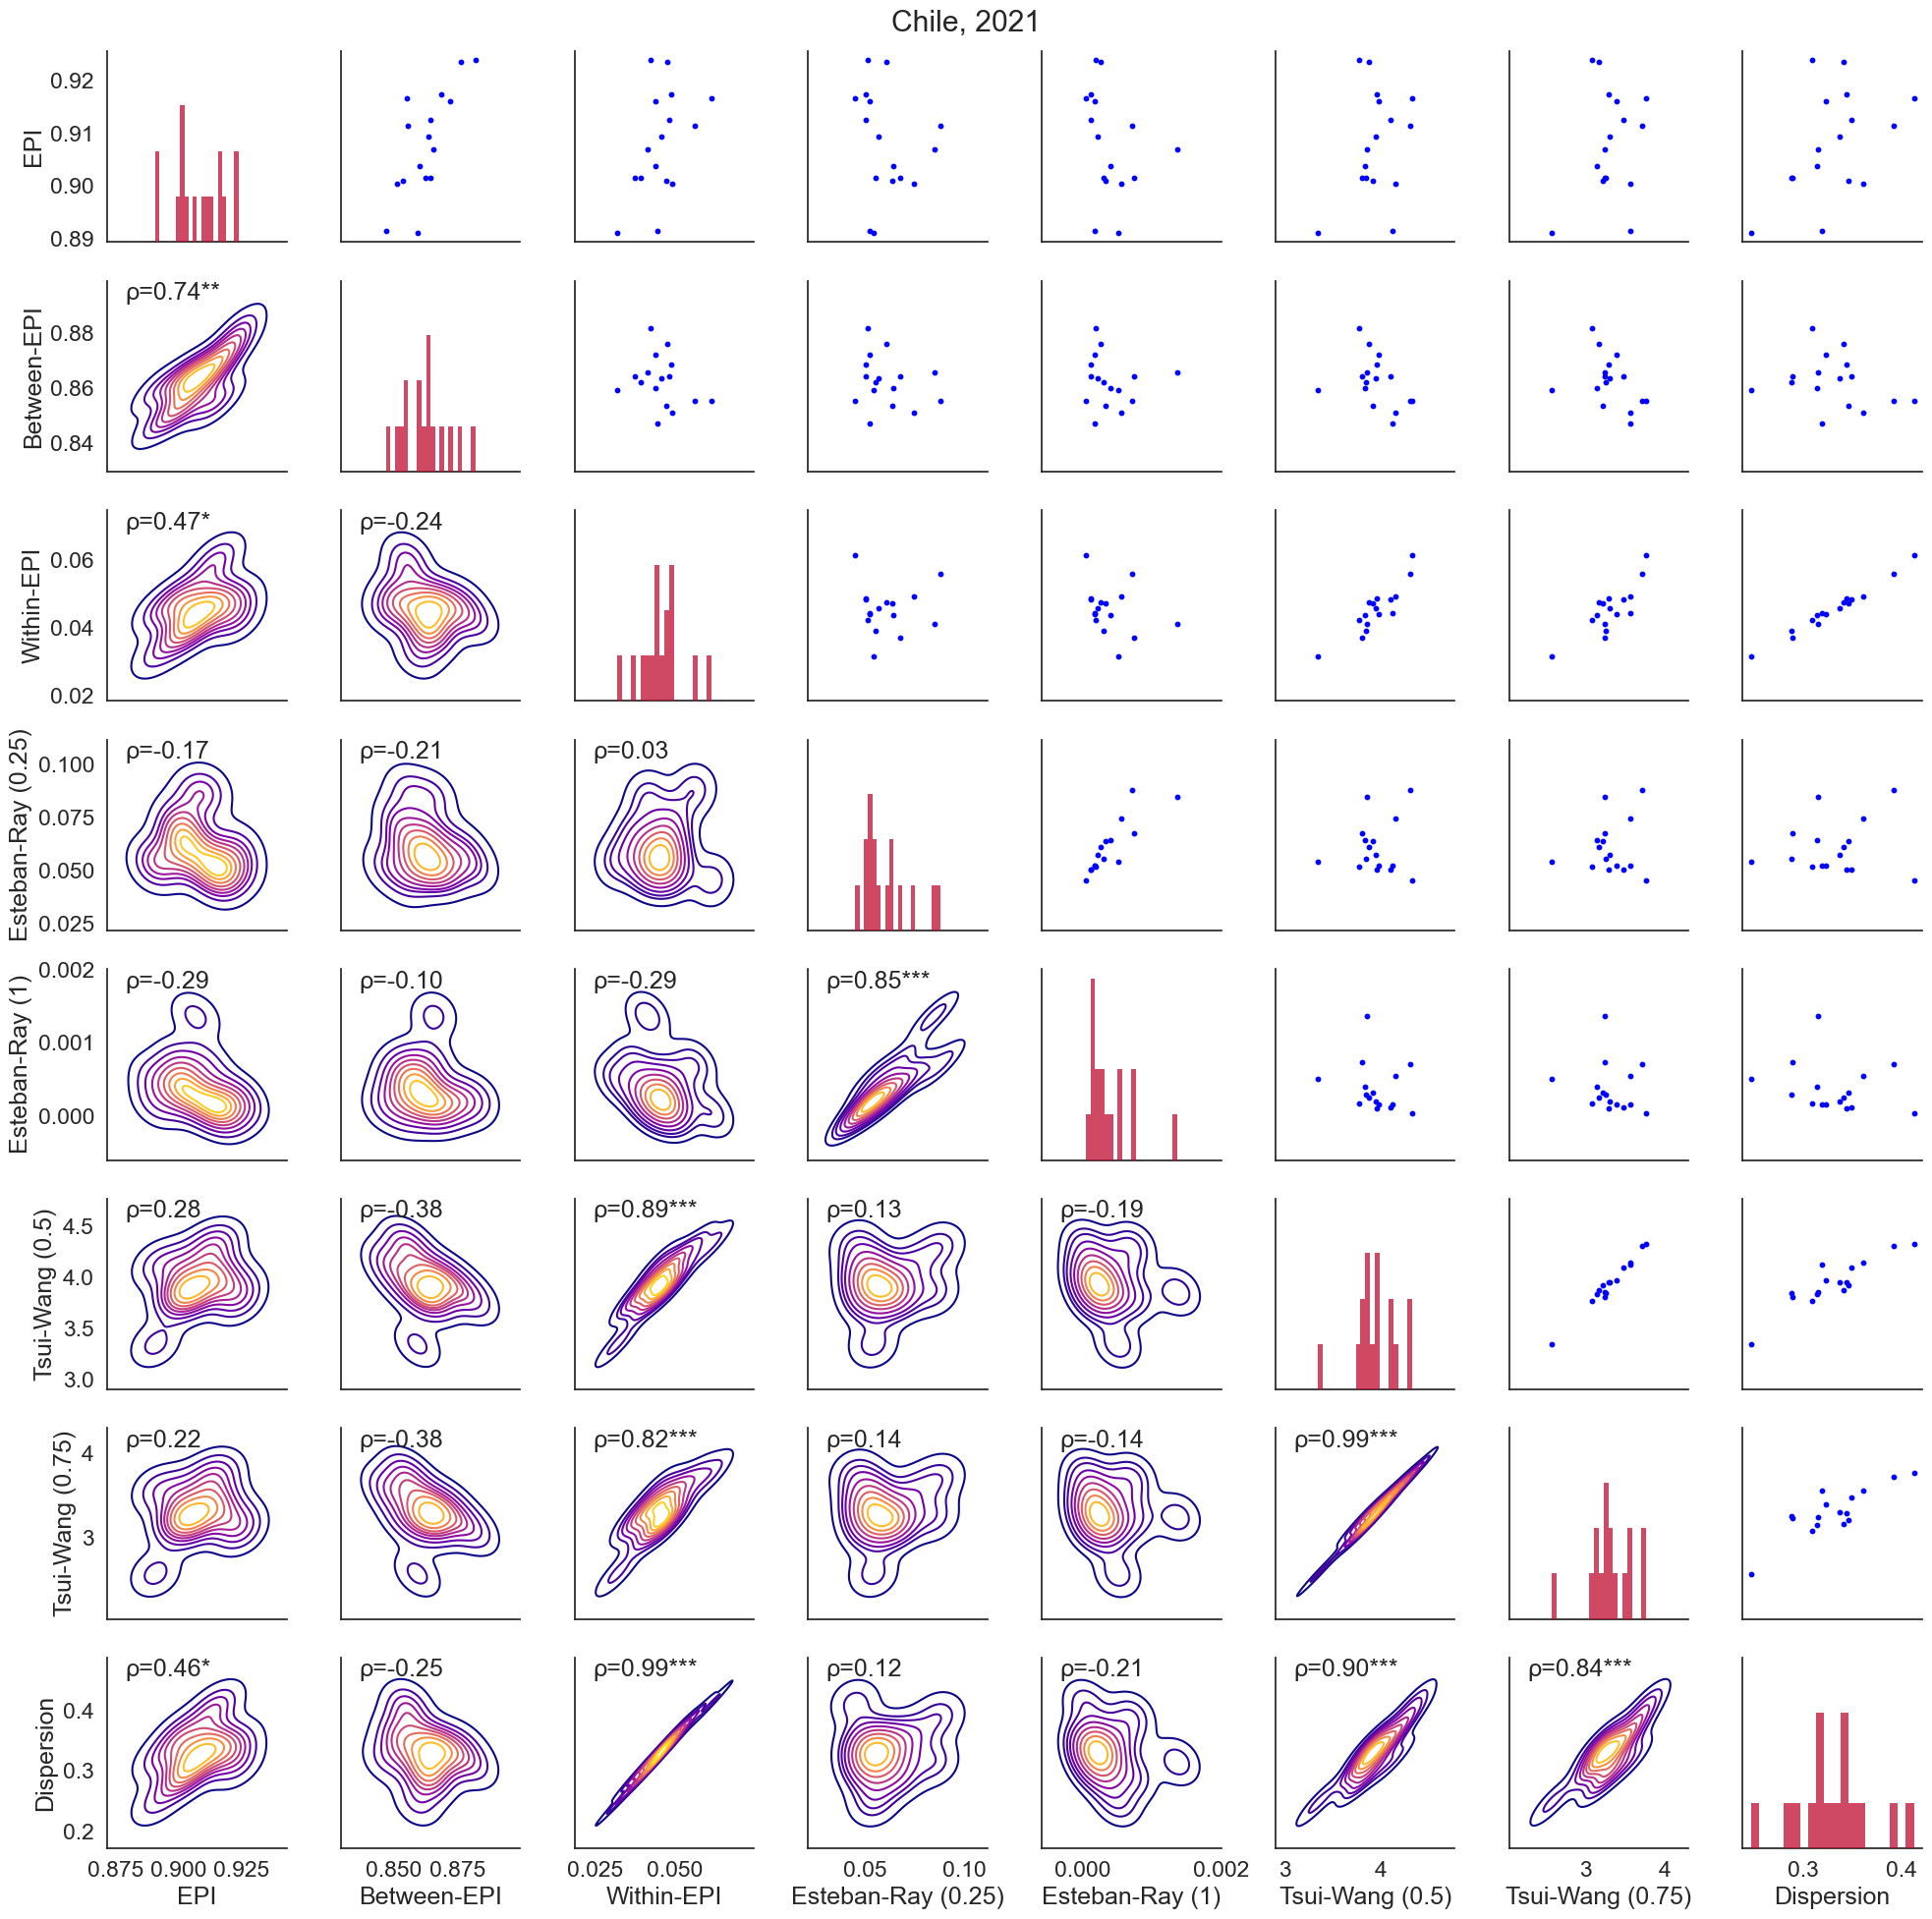

In [12]:
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5, style="white")

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    note = ""
    if _ < 0.001:
        note = "***"
    elif _ < 0.05:
        note = "**"
    elif _ < 0.1:
        note = "*"

    ax.annotate(
        "ρ={:.2f}{}".format(r, note),
        xy=(.1, .9), xycoords=ax.transAxes)

data = dd.pivot(index=[geography], columns="method", values="value").dropna()
data = data[methods.values()]

g = sns.PairGrid(data)
g.map_upper(plt.scatter, color="blue", s=10)
g.map_diag(sns.histplot, kde=False, lw=0, bins=20, color="#BF0A30")
g.map_lower(sns.kdeplot, cmap="plasma")
g.map_lower(corrfunc)
g.fig.suptitle(f"{country}, {year}")

g.fig.tight_layout()

g.fig.savefig(f"Figures_Appendix/Rb_polarization_{country}_{year}.pdf")
